# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


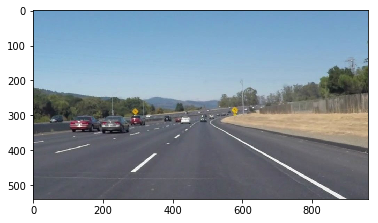

In [13]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteCurve.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [123]:
import math
import operator

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=12):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    """
    To extrapolate the lines, we will separate the left lines and right lines based on slope
    - If slope > 0 it is part of the right line and if slope < 0 it is part of left line.. because 
    coordinate system y is positive downwards.
    - We will put the center points in left and right arrays
    - After getting left and right arrays, we will get the center point from the left array 
      and center point from the right array. We will obtain average slope for the left line 
    and average slope for the right line and 
    - From the center points and slope values we should be able to calculate two extreme points
     which when joined together would extrapolate.
    """
    leftLineMidPoints=[];  # To hold Mid Points of the Left Line
    rightLineMidPoints=[]; # To hold Mid points of right line
    rightLineSlopes=[];    # Slopes > 0, For lines on the right side
    leftLineSlopes=[];     # For lines on left side, slopes <0
    imshape = img.shape;
    for line in lines:
        for x1,y1,x2,y2 in line:
            
            # ignore infinite slopes
            if(x2-x1 != 0):
                m = (y2-y1)/(x2-x1);
                centerPoint = ((x1+x2)/2,((y2+y1)/2));
                if m > 0:
                    # Lines with positive slopes go to the right side
                    if x1 > imshape[1]/2 and x2 > imshape[1]/2:
                        #removing the noise and outliers which overfits the data
                        rightLineMidPoints.append(centerPoint);
                        rightLineSlopes.append(m);
                else:      
                    if x1 < imshape[1]/2 and x2 < imshape[1]/2:
                        #removing the noise and outliers which overfits the data
                        leftLineMidPoints.append(centerPoint);
                        leftLineSlopes.append(m);
        
    # getting the average slopes    
    leftAverageSlope = sum(leftLineSlopes)/len(leftLineSlopes);
    rightAverageSlope = sum(rightLineSlopes)/len(rightLineSlopes);
    
    # Averaging over all the leftLine Points and RightLine Points
    # needs to be done tuple wise so using numpy; axis =0 implies sum row wise
    leftCenterPoint=np.divide(np.sum(leftLineMidPoints,axis=0),len(leftLineMidPoints));
    rightCenterPoint = np.divide(np.sum(rightLineMidPoints,axis=0),len(rightLineMidPoints));
    
    #For left line one point will always pass thru point (x,imshape[0] )
    # having y coordinate with x coordinate unknow and slope is known as well.
    # (LowerLeft = Xcenter - (Ycenter - Ylowerleft)/leftLineSlope) (Point (x,imshape[0]) 
    # and mid point (leftCenterPoint)))
    leftLineLowerX = int(leftCenterPoint[0]-((leftCenterPoint[1]-imshape[0])/leftAverageSlope));

    """As car's camera is mounted in front of the car, these is a limit to the point where car can see. This point is the 
    farthest point (height) to which car can look, so this should be the topmost Y coordinate where Lane line should be drawn.
    """
    regionOfInterestHgt=320;
    # Similary we have a y coordinate and the slope and intercept, we can get the X coordinate
    leftLineUpperX = int(leftCenterPoint[0]+((regionOfInterestHgt-leftCenterPoint[1])/leftAverageSlope));
    if leftLineUpperX >500:
        leftLineUpperX=464;
    
    #For right Line we have centerPoint and extreme point (X,imshape[0]) as right line will also pass thru this point.
    # With the right Line Slope and Y coordinate, we can get the lowerRight Coordinate.
    rightLineLowerX = int(rightCenterPoint[0]-((rightCenterPoint[1]-imshape[0])/rightAverageSlope))
    # Other extreme would be passing thru the point regionOfIntest.
    rightLineUpperX = int(rightCenterPoint[0]+((regionOfInterestHgt-rightCenterPoint[1])/rightAverageSlope));
    #            - Points are (rightLineLowerX, imshape[0]), (rightLineUpperX, regionOfiInterest)
    
    cv2.line(img, (leftLineLowerX,imshape[0]), (leftLineUpperX,regionOfInterestHgt), color, thickness)
    cv2.line(img, (rightLineLowerX,imshape[0]), (rightLineUpperX, regionOfInterestHgt), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [124]:
import os
os.listdir("test_images/")

['frame0.jpg',
 'frame1.jpg',
 'frame10.jpg',
 'frame100.jpg',
 'frame1000.jpg',
 'frame1001.jpg',
 'frame1002.jpg',
 'frame1003.jpg',
 'frame1004.jpg',
 'frame1005.jpg',
 'frame1006.jpg',
 'frame1007.jpg',
 'frame1008.jpg',
 'frame1009.jpg',
 'frame101.jpg',
 'frame1010.jpg',
 'frame1011.jpg',
 'frame1012.jpg',
 'frame1013.jpg',
 'frame1014.jpg',
 'frame1015.jpg',
 'frame1016.jpg',
 'frame1017.jpg',
 'frame1018.jpg',
 'frame1019.jpg',
 'frame102.jpg',
 'frame1020.jpg',
 'frame1021.jpg',
 'frame1022.jpg',
 'frame1023.jpg',
 'frame1024.jpg',
 'frame1025.jpg',
 'frame1026.jpg',
 'frame1027.jpg',
 'frame1028.jpg',
 'frame1029.jpg',
 'frame103.jpg',
 'frame1030.jpg',
 'frame1031.jpg',
 'frame1032.jpg',
 'frame1033.jpg',
 'frame1034.jpg',
 'frame1035.jpg',
 'frame1036.jpg',
 'frame1037.jpg',
 'frame1038.jpg',
 'frame1039.jpg',
 'frame104.jpg',
 'frame1040.jpg',
 'frame1041.jpg',
 'frame1042.jpg',
 'frame1043.jpg',
 'frame1044.jpg',
 'frame1045.jpg',
 'frame1046.jpg',
 'frame1047.jpg',
 'fra

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [127]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

# Converting the image to grayscale
grayImage = grayscale(image);

# Applying Gaussian smoothing
kernelSize = 5;
gaussianImage = gaussian_blur(grayImage, kernelSize);

# Applying CannyEdge to get the points of interest
lowThreshold = 50;
highThreshold = 150;
edgeImage = canny(gaussianImage, lowThreshold, highThreshold);

# Region of interest selection
imshape = image.shape;
vertices = np.array([[(0,imshape[0]),(460, 315), (480, 315), (imshape[1],imshape[0])]], dtype=np.int32)
maskedImage = region_of_interest(edgeImage, vertices);

# Hough Transform on Edge detected image, returns array of lines
# Points are to be joined so as to obtain a line..
# Make a blank the same size as our image to draw on
rho = 2 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 20     # minimum number of votes (intersections in Hough grid cell)
minLineLength = 5 #minimum number of pixels making up a line
maxLineGap = 15    # maximum gap in pixels between connectable line segments

houghLineImage = hough_lines(maskedImage, rho, theta, threshold, minLineLength
                   , maxLineGap);

lineWeightImage = weighted_img(image, houghLineImage);
#plt.imshow(lineWeightImage)







## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [128]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
count =0;

In [129]:
def process_image(image):
    global count
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    # TODO: Build your pipeline that will draw lane lines on the test_images
    # then save them to the test_images directory.

    # Converting the image to grayscale
    grayImage = grayscale(image);

    # Applying Gaussian smoothing
    kernelSize = 5;
    gaussianImage = gaussian_blur(grayImage, kernelSize);

    # Applying CannyEdge to get the points of interest
    lowThreshold = 50;
    highThreshold = 150;
    edgeImage = canny(gaussianImage, lowThreshold, highThreshold);

    # Region of interest selection
    imshape = image.shape;
    vertices = np.array([[(0,imshape[0]),(460, 315), (480, 315), (imshape[1],imshape[0])]], dtype=np.int32)
    maskedImage = region_of_interest(edgeImage, vertices);

    # Hough Transform on Edge detected image, returns array of lines
    # Make a blank the same size as our image to draw on
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 20     # minimum number of votes (intersections in Hough grid cell)
    minLineLength = 5 #minimum number of pixels making up a line
    maxLineGap = 15    # maximum gap in pixels between connectable line segments

    houghLineImage = hough_lines(maskedImage, rho, theta, threshold, minLineLength
                       , maxLineGap);
    #plt.imshow(houghLineImage);

    lineWeightImage = weighted_img(image, houghLineImage);
    #plt.imshow(lineWeightImage);
    cv2.imwrite("test_images/frame{:d}.jpg".format(count),lineWeightImage);
    count+=1
    return lineWeightImage

Let's try the one with the solid white lane on the right first ...

In [130]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:10<00:00, 21.07it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 6.89 s, sys: 800 ms, total: 7.69 s
Wall time: 11.1 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [131]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [132]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:33<00:00, 20.46it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 22.5 s, sys: 2.21 s, total: 24.7 s
Wall time: 34.1 s


In [133]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [100]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[ 375.30769231  522.09615385]
[ 705.6509434   479.96226415]
-634 464
1320 295
[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


  0%|          | 0/251 [00:00<?, ?it/s]

[ 375.30769231  522.09615385]
[ 705.6509434   479.96226415]
-634 464
1320 295
[ 351.05681818  512.51136364]
[ 738.24418605  502.41860465]
-236 464
1124 414


  1%|          | 3/251 [00:00<00:24, 10.15it/s]

[ 321.75      541.359375]
[ 723.37962963  478.98148148]
-380 464
1226 391


  2%|▏         | 4/251 [00:00<00:24, 10.05it/s]

[ 346.19047619  546.4047619 ]
[ 702.76829268  477.96341463]
183 464
1383 258


  2%|▏         | 5/251 [00:00<00:24,  9.87it/s]

[ 346.46296296  542.31481481]
[ 739.71568627  509.8627451 ]
-111 464
1309 224


  2%|▏         | 6/251 [00:00<00:25,  9.56it/s]

[ 341.74358974  563.96153846]
[ 687.96491228  462.85087719]
-48 464
1421 280


  3%|▎         | 7/251 [00:00<00:25,  9.49it/s]

[ 351.91666667  560.51190476]
[ 743.35897436  498.08974359]
164 464
1293 301


  3%|▎         | 8/251 [00:00<00:25,  9.56it/s]

[ 363.85227273  528.01136364]
[ 702.06862745  477.        ]
-329 464
1303 313


  4%|▎         | 9/251 [00:00<00:25,  9.62it/s]

[ 343.83333333  540.80701754]
[ 668.93617021  461.42553191]
-292 464
1117 423


  4%|▍         | 10/251 [00:01<00:25,  9.54it/s]

[ 346.0483871   514.01612903]
[ 686.86046512  464.88372093]
-801 464
1155 420


  4%|▍         | 11/251 [00:01<00:25,  9.38it/s]

[ 331.88709677  542.91935484]
[ 716.875       482.57954545]
-105 464
1241 357


  5%|▍         | 12/251 [00:01<00:25,  9.34it/s]

[ 337.63043478  511.05434783]
[ 737.16923077  488.80769231]
30 464
1309 319


  5%|▌         | 13/251 [00:01<00:25,  9.39it/s]

[ 326.1097561   577.86585366]
[ 754.81746032  523.05555556]
-86 464
1197 298


  6%|▌         | 14/251 [00:01<00:25,  9.47it/s]

[ 356.91666667  531.48333333]
[ 735.34482759  489.96551724]
142 464
1281 331


  6%|▌         | 15/251 [00:01<00:24,  9.44it/s]

[ 353.32432432  556.18918919]
[ 734.46491228  514.49122807]
20 464
1035 449
[ 324.65217391  532.73913043]
[ 701.7625  473.0375]
-324 464
1266 351
[ 330.87837838  541.51351351]
[ 708.71568627  470.64705882]
-326 464
1303 349


  7%|▋         | 17/251 [00:01<00:23,  9.76it/s]

[ 315.8125      501.79166667]
[ 701.20634921  473.61111111]
-749 464
1367 285


  8%|▊         | 19/251 [00:01<00:23, 10.08it/s]

[ 365.90384615  498.46153846]
[ 720.01639344  487.63934426]
-236 464
1110 438
[ 341.10714286  516.88095238]
[ 684.59322034  467.27966102]
-249 464
1233 364
[ 344.42307692  512.5       ]
[ 667.375      455.2421875]
-544 464
1028 482


  8%|▊         | 21/251 [00:02<00:22, 10.26it/s]

[ 330.02857143  592.52857143]
[ 677.03773585  453.41509434]
-20 464
1242 393
[ 340.046875  513.921875]
[ 711.25609756  481.99390244]
-89 464
1262 336


  9%|▉         | 23/251 [00:02<00:21, 10.79it/s]

[ 337.51388889  547.95833333]
[ 732.04861111  477.26388889]
-270 464
1199 429


 10%|▉         | 25/251 [00:02<00:20, 10.88it/s]

[ 326.56451613  552.48387097]
[ 738.03968254  492.22222222]
-122 464
1197 390
[ 328.02857143  571.32857143]
[ 722.7265625  482.546875 ]
-200 464
1219 382
[ 334.92307692  574.69230769]
[ 721.475  483.9  ]
-165 464
1088 466


 11%|█         | 27/251 [00:02<00:20, 10.97it/s]

[ 336.515625  525.046875]
[ 651.5890411   442.07534247]
-304 464
1312 361
[ 350.72580645  591.82258065]

 12%|█▏        | 29/251 [00:02<00:21, 10.25it/s]


[ 684.52112676  462.0915493 ]
74 464
1237 379


 12%|█▏        | 31/251 [00:03<00:21, 10.33it/s]

[ 342.75714286  517.97142857]
[ 682.00666667  454.46666667]
-405 464
1209 414
[ 341.425  557.975]
[ 715.54225352  479.59859155]
-170 464
1152 425
[ 350.171875  529.125   ]
[ 662.58536585  450.77439024]
-745 464
1209 397


 13%|█▎        | 33/251 [00:03<00:20, 10.59it/s]

[ 346.08695652  525.98913043]
[ 684.72988506  450.86206897]
-261 464
1188 439
[ 337.52380952  545.92857143]
[ 719.45833333  467.32142857]
-692 464
1185 447
[ 353.92592593  555.22222222]
[ 679.60619469  459.78761062]
-70 464
1189 405


 15%|█▍        | 37/251 [00:03<00:18, 11.30it/s]

[ 335.79487179  552.56410256]
[ 667.5         443.44318182]
-201 464
1147 453
[ 351.06097561  589.02439024]
[ 691.81666667  471.2       ]
103 464
1150 413
[ 328.67391304  563.43478261]
[ 698.48780488  470.69512195]
-122 464
1060 479


 16%|█▌        | 39/251 [00:03<00:18, 11.22it/s]

[ 357.63636364  497.60606061]
[ 690.76373626  457.67032967]
-325 464
1099 476
[ 356.52857143  537.98571429]
[ 659.3622449   445.63265306]
-91 464
1201 411
[ 352.359375  564.4375  ]
[ 658.41549296  440.18309859]
-113 464
1124 458


 17%|█▋        | 43/251 [00:04<00:19, 10.85it/s]

[ 311.     555.875]
[ 654.63106796  447.23786408]
-358 464
1201 399
[ 347.19444444  511.41666667]
[ 638.50434783  433.6       ]
-436 464
1141 439
[ 345.32758621  537.31034483]
[ 636.66326531  432.92857143]
180 464
1218 407


 18%|█▊        | 45/251 [00:04<00:18, 10.91it/s]

[ 346.23333333  520.76666667]
[ 655.53900709  442.91134752]
-450 464
1207 410
[ 356.86956522  531.23913043]
[ 651.95348837  440.44573643]
-360 464
1195 417
[ 339.66666667  506.72222222]
[ 648.20437956  442.78467153]
17 464
1205 401


 20%|█▉        | 49/251 [00:04<00:18, 10.84it/s]

[ 343.21153846  520.40384615]
[ 660.00364964  441.27007299]
-480 464
1096 469
[ 324.43103448  538.84482759]
[ 659.88590604  443.30536913]
-267 464
1187 424
[ 332.23611111  570.56944444]
[ 633.04794521  435.00342466]
-141 464
1053 463


 20%|██        | 51/251 [00:04<00:18, 10.69it/s]

[ 339.18571429  554.2       ]
[ 617.2480315   423.75984252]
-276 464
1075 456
[ 334.33333333  560.25641026]
[ 603.88988095  417.80654762]
-40 464
1040 462
[ 331.0875  569.1875]
[ 608.740625  427.109375]
107 464
1074 438


 22%|██▏       | 55/251 [00:05<00:18, 10.46it/s]

[ 303.5         562.16666667]
[ 628.85904255  434.73138298]
-155 464
1065 453
[ 327.66  571.94]
[ 614.80909091  428.16363636]
-15 464
1086 439
[ 340.40322581  538.67741935]
[ 608.23021583  424.16906475]
-183 464
1123 426


 23%|██▎       | 57/251 [00:05<00:18, 10.37it/s]

[ 321.85526316  555.46052632]
[ 616.34768212  432.24834437]
-386 464
1036 452
[ 342.08139535  498.12790698]
[ 625.19642857  445.52857143]
105 464
862 516
[ 360.39583333  518.97916667]
[ 630.39506173  435.67901235]
-511 464
1142 421


 24%|██▍       | 61/251 [00:05<00:18, 10.10it/s]

[ 360.86206897  494.64655172]
[ 624.51623377  442.25649351]
-206 464
923 492
[ 355.01851852  533.7654321 ]
[ 654.30530973  456.9159292 ]
121 464
943 504
[ 332.27272727  574.30909091]
[ 639.70322581  448.8516129 ]
-73 464
1113 414


 25%|██▌       | 63/251 [00:06<00:18, 10.12it/s]

[ 367.18867925  517.66037736]
[ 598.92279412  422.59558824]
-9 464
825 520
[ 379.4375     496.7265625]
[ 636.81205674  441.0035461 ]
129 464
1271 361


 26%|██▋       | 66/251 [00:06<00:19,  9.53it/s]

[ 367.30232558  502.06976744]
[ 581.40145985  421.54379562]
-397 464
939 459
[ 364.89772727  501.07954545]
[ 612.21428571  434.92857143]
-282 464
839 520


 27%|██▋       | 68/251 [00:06<00:19,  9.49it/s]

[ 370.7983871   496.53225806]
[ 606.24747475  435.17676768]
124 464
741 551
[ 366.19672131  494.09836066]
[ 656.21938776  458.65816327]
-283 464
758 602


 28%|██▊       | 70/251 [00:06<00:19,  9.52it/s]

[ 359.63768116  471.86956522]
[ 649.05797101  463.        ]
-461 464
760 586
[ 351.59821429  495.16964286]
[ 645.51136364  454.90340909]
-58 464
949 490


 29%|██▊       | 72/251 [00:07<00:18,  9.55it/s]

[ 357.68181818  501.40340909]
[ 674.12658228  479.40506329]
107 464
811 583
[ 357.38461538  495.33974359]
[ 685.02083333  481.984375  ]
-58 464
939 511


 29%|██▉       | 74/251 [00:07<00:19,  9.15it/s]

[ 370.325    484.51875]
[ 692.63125  489.91875]
230 467
939 510
[ 353.44444444  514.17676768]
[ 688.34  481.12]
145 464
862 571


 30%|███       | 76/251 [00:07<00:19,  8.92it/s]

[ 381.65789474  486.96710526]
[ 650.31967213  449.14754098]
146 464
874 543
[ 371.52272727  486.28030303]
[ 642.32394366  456.1056338 ]
-4 464
801 560


 31%|███       | 77/251 [00:07<00:19,  9.03it/s]

[ 365.51515152  492.12121212]
[ 679.76811594  473.39855072]
-276 464
882 553
[ 349.78378378  493.06756757]
[ 693.85        491.19444444]
-148 464
913 529
[ 354.85204082  499.2244898 ]

 32%|███▏      | 80/251 [00:07<00:18,  9.02it/s]


[ 640.91772152  455.64556962]
-462 464
891 512
[ 348.3814433   513.24226804]
[ 695.36507937  479.85714286]
-115 464
960 518
[ 350.53478261  502.26956522]
[ 665.48214286  494.05357143]
-382 464
804 558


 33%|███▎      | 82/251 [00:08<00:20,  8.25it/s]

[ 342.14224138  515.92672414]
[ 713.94166667  504.80833333]
-187 464
882 569
[ 334.1978022  507.5989011]
[ 671.34285714  479.97857143]
-350 464
898 519


 33%|███▎      | 84/251 [00:08<00:21,  7.93it/s]

[ 331.66071429  510.76785714]
[ 660.80701754  472.14912281]
-308 464
756 601
[ 337.50869565  517.86956522]
[ 666.33695652  481.10869565]
-317 464
1021 426


 35%|███▍      | 87/251 [00:08<00:19,  8.44it/s]

[ 327.11111111  530.875     ]
[ 740.925  494.1  ]
-424 464
1429 210
[ 337.86170213  524.65957447]
[ 663.11016949  487.99152542]
-139 464
1172 294


 35%|███▌      | 88/251 [00:08<00:20,  8.10it/s]

[ 314.61538462  528.76035503]
[ 660.5         479.96202532]
-199 464
911 492
[ 307.20165746  544.78453039]
[ 696.25757576  489.92424242]
-304 464
1161 352


 36%|███▋      | 91/251 [00:09<00:18,  8.42it/s]

[ 295.46682464  552.2535545 ]
[ 713.16346154  504.78846154]
-180 464
1424 102
[ 311.88292683  558.46341463]
[ 678.16666667  506.42592593]
-211 464
867 512


 37%|███▋      | 93/251 [00:09<00:18,  8.47it/s]

[ 316.10515873  548.69047619]
[ 675.24615385  481.95384615]
71 464
1236 293
[ 326.68918919  546.06216216]
[ 736.41818182  504.64545455]
-13 464
1256 290


 38%|███▊      | 95/251 [00:09<00:17,  8.71it/s]

[ 299.52674897  569.86625514]
[ 707.83636364  501.6       ]
-71 464
1188 308
[ 321.06122449  550.31632653]
[ 730.62  504.06]
82 464
1147 375


 39%|███▊      | 97/251 [00:09<00:17,  8.93it/s]

[ 326.08381503  536.26878613]
[ 683.70547945  482.93150685]
-70 464
978 481
[ 315.77251185  550.16824645]
[ 672.82608696  494.49275362]
-34 464
1103 339


 39%|███▉      | 99/251 [00:10<00:16,  8.95it/s]

[ 308.49180328  558.09562842]
[ 643.88461538  487.37362637]
-99 464
1107 310
[ 306.79943503  555.28531073]
[ 661.69402985  477.70149254]
-75 464
1223 296


 40%|████      | 101/251 [00:10<00:17,  8.81it/s]

[ 287.52352941  559.37352941]
[ 623.12886598  438.11340206]
-281 464
1140 406
[ 277.23630137  554.89041096]
[ 676.21153846  461.57692308]
-3 464
1090 448
[ 301.02413793  547.22068966]
[ 660.72794118  465.30882353]
2 464
920 512


 41%|████      | 103/251 [00:10<00:15,  9.41it/s]

[ 329.96341463  506.80894309]
[ 668.87745098  465.52941176]
61 464
1149 393
[ 331.35326087  520.60326087]
[ 658.735  453.115]
-62 464
885 545
[ 343.5875   511.20625]
[ 656.69306931  446.24257426]
-184 464
1051 474


 43%|████▎     | 107/251 [00:10<00:15,  9.41it/s]

[ 343.09615385  532.64423077]
[ 730.37634409  498.90322581]
107 464
1093 436
[ 353.88202247  529.37640449]
[ 709.61   506.805]
-512 464
840 594


 43%|████▎     | 109/251 [00:11<00:15,  8.93it/s]

[ 339.16911765  530.91176471]
[ 738.35714286  516.77857143]
-151 464
1047 438
[ 308.97530864  583.50617284]
[ 737.23076923  520.8951049 ]
-490 464
981 490


 44%|████▍     | 111/251 [00:11<00:15,  8.82it/s]

[ 339.42405063  502.55063291]
[ 756.35643564  531.97524752]
-241 464
1054 420
[ 344.20454545  487.35606061]
[ 744.79439252  514.54672897]
-108 464
1035 469


 45%|████▍     | 112/251 [00:11<00:17,  8.13it/s]

[ 343.76760563  490.62676056]
[ 691.76642336  484.83576642]
-345 464
983 487
[ 362.86986301  495.83561644]
[ 687.08522727  480.29545455]
-473 464
927 526


 45%|████▌     | 114/251 [00:11<00:15,  8.64it/s]

[ 341.9         492.79090909]
[ 687.85849057  471.04716981]
-297 464
994 501
[ 365.38461538  469.72307692]
[ 629.6559633   469.93119266]
-329 464
910 461
[ 337.16  504.71]
[ 620.04591837  448.17857143]
-384 464
918 479


 47%|████▋     | 118/251 [00:12<00:13,  9.58it/s]

[ 343.27631579  507.84210526]
[ 694.54878049  483.83536585]
-293 464
1156 373
[ 361.2712766   507.00531915]
[ 666.73417722  456.73417722]
69 464
1023 481
[ 333.58088235  511.97058824]
[ 649.07142857  438.73809524]
-8 464
1278 383


 48%|████▊     | 121/251 [00:12<00:14,  9.23it/s]

[ 340.71052632  484.61842105]
[ 644.13551402  451.46728972]
-95 464
1036 452
[ 331.60273973  484.36986301]
[ 655.57462687  455.29104478]
-254 464
1191 381


 49%|████▉     | 123/251 [00:12<00:13,  9.16it/s]

[ 352.25373134  470.74626866]
[ 688.292  467.504]
-300 464
1151 417
[ 353.65217391  472.63043478]
[ 723.54545455  487.3       ]
-353 464
1015 513


 49%|████▉     | 124/251 [00:12<00:13,  9.25it/s]

[ 351.5375  482.1875]
[ 683.38356164  483.89726027]
190 461
1079 408
[ 345.35211268  488.62676056]
[ 658.56849315  457.09589041]
-322 464
836 565


 51%|█████     | 127/251 [00:13<00:13,  9.09it/s]

[ 335.2797619   515.80357143]
[ 662.88414634  469.07317073]
-229 464
1450 194
[ 331.5        496.6741573]
[ 653.84158416  458.93564356]
-107 464
963 489


 51%|█████▏    | 129/251 [00:13<00:13,  9.24it/s]

[ 312.59649123  572.20175439]
[ 678.04945055  457.41758242]
-233 464
951 534
[ 351.39189189  492.13513514]
[ 680.37719298  466.0877193 ]
-163 464
1279 335


 52%|█████▏    | 131/251 [00:13<00:12,  9.26it/s]

[ 360.43269231  495.46153846]
[ 664.425  457.625]
-124 464
1018 478
[ 347.20833333  510.17361111]
[ 670.52985075  473.08208955]
-148 464
1022 452


 53%|█████▎    | 133/251 [00:13<00:12,  9.08it/s]

[ 343.71333333  496.56      ]
[ 707.92982456  487.93859649]
144 464
1056 455
[ 360.71323529  481.625     ]
[ 739.31666667  503.09166667]
79 464
1117 420


 54%|█████▍    | 135/251 [00:14<00:12,  9.13it/s]

[ 363.71323529  479.26470588]
[ 750.91525424  518.77966102]
-100 464
1250 257
[ 358.51351351  487.00900901]
[ 665.74242424  467.75      ]
151 464
1318 283


 55%|█████▍    | 137/251 [00:14<00:12,  9.18it/s]

[ 355.22077922  478.09090909]
[ 754.95283019  520.77358491]
-11 464
1199 307
[ 345.51428571  470.80952381]
[ 671.92391304  472.34782609]
-27 464
1387 231


 55%|█████▌    | 139/251 [00:14<00:11,  9.49it/s]

[ 353.99456522  467.17934783]
[ 694.58695652  487.        ]
-146 464
1328 240
[ 355.94705882  480.9       ]
[ 666.59259259  481.01851852]
-106 464
1388 179
[ 336.73684211  520.82236842]
[ 735.98780488  509.44512195]
-88 464
1308 220


 57%|█████▋    | 142/251 [00:14<00:11,  9.51it/s]

[ 345.7625   504.98125]
[ 675.3253012   495.91566265]
-289 464
1274 204
[ 355.1953125  489.9453125]
[ 730.54        496.11333333]
-89 464
1312 273


 57%|█████▋    | 144/251 [00:15<00:11,  9.17it/s]

[ 349.29411765  507.65686275]
[ 742.53333333  514.80666667]
190 489
1029 470
[ 317.38888889  552.49305556]
[ 712.72222222  518.4017094 ]
-398 464
1194 238


 58%|█████▊    | 146/251 [00:15<00:11,  9.25it/s]

[ 298.77710843  534.06024096]
[ 794.25882353  549.32352941]
-313 464
1249 182
[ 314.86986301  562.55479452]
[ 759.18852459  569.25819672]
-163 464
1032 307


 59%|█████▉    | 148/251 [00:15<00:11,  9.13it/s]

[ 317.82677165  556.2007874 ]
[ 717.62962963  584.97407407]
-274 464
1108 -50
[ 300.86643836  579.63013699]
[ 727.56363636  573.40454545]
-144 464
1092 96


 59%|█████▉    | 149/251 [00:15<00:11,  9.24it/s]

[ 292.20987654  580.55555556]
[ 773.20430108  581.09677419]
19 464
1141 80
[ 280.53164557  581.14556962]
[ 757.6875  526.4625]
-28 464
973 527
[ 298.67410714  565.79464286]
[ 791.43125  529.95625]
-197 464
1305 223


 61%|██████    | 152/251 [00:15<00:10,  9.33it/s]

[ 315.31578947  543.80921053]
[ 778.70212766  524.34042553]
-199 464
1208 329
[ 317.98734177  557.64556962]
[ 733.0212766   500.03191489]
-187 464
1393 192
[ 292.06637168  576.75221239]
[ 722.9375    534.328125]
-149 464
1227 139


 62%|██████▏   | 156/251 [00:16<00:09,  9.92it/s]

[ 276.17222222  583.65      ]
[ 799.01388889  540.20833333]
-235 464
1171 342
[ 278.07333333  580.03333333]
[ 757.41666667  534.31481481]
-112 464
1308 120
[ 295.43220339  578.92372881]
[ 777.91071429  557.625     ]
-361 464
1023 418


 63%|██████▎   | 158/251 [00:16<00:09, 10.22it/s]

[ 351.22340426  540.06382979]
[ 731.20930233  508.77906977]
-186 464
1474 66
[ 345.68421053  546.15789474]
[ 715.          467.63043478]
-444 464
995 550
[ 323.109375   539.9453125]
[ 778.5         508.48275862]
-328 464
1239 367


 65%|██████▍   | 162/251 [00:16<00:08, 10.88it/s]

[ 332.68085106  524.65957447]
[ 808.625  516.25 ]
-345 464
1280 353
[ 288.21875     579.77083333]
[ 703.69565217  487.2826087 ]
-362 464
1018 477
[ 338.56521739  520.42391304]
[ 822.75757576  537.15151515]
-148 464
1212 359


 65%|██████▌   | 164/251 [00:16<00:07, 11.22it/s]

[ 337.3125   514.78125]
[ 778.64444444  496.82222222]
-268 464
1234 417
[ 333.37804878  514.        ]
[ 762.35   495.475]
-386 464
1191 427
[ 334.54054054  522.52702703]
[ 716.34444444  482.57777778]
-4 464
1233 361


 67%|██████▋   | 168/251 [00:17<00:07, 11.30it/s]

[ 318.16666667  554.39215686]
[ 753.13636364  505.39393939]
-227 464
1235 336
[ 342.61363636  554.29545455]
[ 726.62  488.59]
-272 464
1200 381
[ 331.58928571  528.05357143]
[ 714.75    480.5625]
-165 464
1299 322


 68%|██████▊   | 170/251 [00:17<00:07, 11.44it/s]

[ 342.15625   522.203125]
[ 690.7173913  470.7826087]
-418 464
1235 361
[ 337.078125  561.40625 ]
[ 653.10465116  440.1627907 ]
-58 464
1329 362
[ 348.5   498.25]
[ 705.28301887  476.44339623]
-535 464
1080 464


 69%|██████▉   | 174/251 [00:17<00:06, 11.54it/s]

[ 348.77777778  498.33333333]
[ 692.65384615  469.42307692]
-873 464
1158 414
[ 342.52702703  543.54054054]
[ 724.38297872  500.23404255]
-187 464
1148 376
[ 363.          494.13636364]
[ 693.5625   455.90625]
-430 464
1208 428


 70%|███████   | 176/251 [00:17<00:06, 11.68it/s]

[ 363.84146341  525.34146341]
[ 660.43055556  464.93055556]
-86 464
1182 363
[ 343.9   546.65]
[ 717.91176471  483.07352941]
-314 464
1113 445
[ 362.91666667  511.65625   ]
[ 728.08163265  477.51020408]
-152 464
1270 376


 72%|███████▏  | 180/251 [00:18<00:06, 11.42it/s]

[ 337.20930233  521.77906977]
[ 718.38888889  464.46666667]
-481 464
1215 437
[ 364.9047619   469.83333333]
[ 732.68181818  487.98863636]
-316 464
1122 450
[ 354.4125  529.125 ]
[ 708.765625  460.171875]
77 464
1267 407


 73%|███████▎  | 182/251 [00:18<00:06, 11.18it/s]

[ 349.78888889  488.08888889]
[ 646.77906977  421.70930233]
-224 464
1387 394
[ 354.77777778  524.55555556]
[ 662.13513514  440.35135135]
-194 464
1344 368
[ 364.296875  517.703125]
[ 671.16346154  444.19230769]
13 464
1247 411


 74%|███████▍  | 186/251 [00:18<00:05, 11.36it/s]

[ 357.80645161  516.88709677]
[ 661.39230769  451.23076923]
-180 464
1126 434
[ 356.04081633  525.39795918]
[ 657.625       448.95192308]
175 464
1244 378
[ 345.91111111  486.91111111]
[ 666.67346939  454.74489796]
-275 464
1145 423


 75%|███████▍  | 188/251 [00:19<00:05, 11.49it/s]

[ 348.43055556  528.43055556]
[ 672.3245614   455.87719298]
-329 464
1308 345
[ 350.29591837  521.86734694]
[ 699.96875   458.828125]
-32 464
1202 432
[ 341.08333333  567.54166667]
[ 685.17910448  453.29104478]
-45 464
1205 425


 76%|███████▋  | 192/251 [00:19<00:05, 11.45it/s]

[ 324.80645161  501.74193548]
[ 741.75892857  490.86607143]
-491 464
1124 456
[ 345.77142857  512.01428571]
[ 715.89230769  473.73846154]
-26 464
1248 383
[ 333.65384615  523.98076923]
[ 660.35915493  448.45070423]
-672 464
925 534


 77%|███████▋  | 194/251 [00:19<00:05, 11.25it/s]

[ 351.2         528.16666667]
[ 713.77160494  472.31481481]
-876 464
1175 429
[ 335.61666667  534.6       ]
[ 677.11971831  456.29577465]
-903 464
1077 469
[ 354.48780488  522.47560976]
[ 676.76229508  465.87704918]
-455 464
1242 351


 79%|███████▉  | 198/251 [00:19<00:04, 10.98it/s]

[ 363.61764706  522.27941176]
[ 714.28703704  481.02777778]
-378 464
961 547
[ 356.4         536.38888889]
[ 711.93421053  497.57894737]
-163 464
1211 313


 80%|███████▉  | 200/251 [00:20<00:04, 10.98it/s]

[ 340.725  577.75 ]
[ 697.54166667  452.48958333]
-55 464
1173 461
[ 356.13157895  549.65789474]
[ 701.47115385  467.08653846]
121 464
1110 463
[ 362.91111111  524.82222222]
[ 775.45833333  506.56666667]
-128 464
1205 399


 80%|████████  | 202/251 [00:20<00:04, 10.80it/s]

[ 337.85  591.8 ]
[ 734.40909091  510.25      ]
-77 464
1213 300
[ 345.32352941  527.86764706]
[ 746.70512821  486.69230769]
-157 464
1212 414
[ 361.85  554.9 ]
[ 754.01190476  506.78571429]
-919 464
1060 485


 82%|████████▏ | 206/251 [00:20<00:04, 10.73it/s]

[ 348.73076923  518.19230769]
[ 688.5         461.29411765]
-258 464
1032 500
[ 345.86585366  516.        ]
[ 732.7826087   481.93478261]
-286 464
1239 388
[ 324.68421053  537.5       ]
[ 647.65254237  451.57627119]
-254 464
912 517


 83%|████████▎ | 208/251 [00:20<00:03, 10.93it/s]

[ 351.21666667  520.28333333]
[ 697.79807692  472.77884615]
-291 464
1029 492
[ 359.04285714  508.65714286]
[ 668.03947368  462.34210526]
-103 464
1181 384
[ 360.41176471  523.31372549]
[ 702.39215686  474.93137255]
-109 464
1056 478


 84%|████████▍ | 212/251 [00:21<00:03, 10.85it/s]

[ 359.62698413  542.50793651]
[ 653.20714286  448.82857143]
-21 464
1301 345
[ 356.97457627  523.94915254]
[ 765.43  501.34]
45 464
1143 452
[ 342.77419355  499.88709677]
[ 729.17924528  491.35849057]
-97 464
1194 380


 85%|████████▌ | 214/251 [00:21<00:03, 10.76it/s]

[ 342.60416667  540.70833333]
[ 690.78947368  473.92982456]
-228 464
1033 476
[ 350.26829268  496.13414634]
[ 735.975   482.2625]
120 464
974 572
[ 346.57142857  538.51190476]
[ 685.69642857  465.25892857]
-222 464
1211 385


 87%|████████▋ | 218/251 [00:21<00:02, 11.09it/s]

[ 370.56060606  529.16666667]
[ 722.          481.78571429]
102 464
1269 350
[ 345.34615385  530.75      ]
[ 678.25609756  465.40243902]
-885 464
851 579
[ 341.57142857  516.67142857]
[ 729.23636364  467.39090909]
-369 464
1202 452


 88%|████████▊ | 220/251 [00:21<00:02, 11.06it/s]

[ 345.55172414  519.37931034]
[ 670.1375  443.225 ]
-924 464
1103 477
[ 351.94047619  502.5952381 ]
[ 680.89285714  453.66964286]
-384 464
1046 497
[ 335.84722222  503.81944444]
[ 656.01666667  444.48333333]
-407 464
1059 473


 89%|████████▉ | 224/251 [00:22<00:02, 11.12it/s]

[ 348.33333333  506.80555556]
[ 734.03846154  488.62820513]
-633 464
875 630
[ 354.25        512.28333333]
[ 691.16666667  464.14492754]
-398 464
1086 468
[ 339.61111111  535.83333333]
[ 716.54032258  484.06451613]
33 464
962 545


 90%|█████████ | 226/251 [00:22<00:02, 10.82it/s]

[ 362.64864865  518.43243243]
[ 688.69791667  474.51041667]
21 464
886 564
[ 355.13461538  514.28846154]
[ 694.85915493  469.59859155]
-1265 464
1002 511
[ 357.68  572.64]
[ 676.40740741  461.2037037 ]
-85 464
829 592


 92%|█████████▏| 230/251 [00:22<00:01, 10.87it/s]

[ 341.14864865  563.58108108]
[ 704.35416667  473.11458333]
-53 464
1225 381
[ 363.125  539.725]
[ 684.83898305  463.88983051]
263 484
846 594
[ 358.65625     547.52083333]
[ 670.94545455  452.51818182]
-97 464
969 523


 92%|█████████▏| 232/251 [00:23<00:01, 10.49it/s]

[ 359.60465116  500.48837209]
[ 634.64  443.19]
-131 464
930 503
[ 359.64423077  531.68269231]
[ 629.21276596  427.4787234 ]
140 464
946 512
[ 354.05102041  518.06122449]
[ 713.97916667  476.11458333]
-143 464
1011 523


 94%|█████████▍| 236/251 [00:23<00:01, 10.55it/s]

[ 357.48611111  492.875     ]
[ 710.74074074  463.62962963]
-204 464
1198 437
[ 312.640625  568.9375  ]
[ 684.08219178  451.43150685]
-221 464
1177 442
[ 326.925  542.5  ]
[ 670.10714286  444.8452381 ]
-581 464
935 549


 95%|█████████▍| 238/251 [00:23<00:01, 10.80it/s]

[ 363.28947368  534.15789474]
[ 699.25       467.7578125]
276 463
917 571
[ 336.97916667  537.64583333]
[ 645.18  447.93]
-91 464
806 569
[ 337.20967742  581.98387097]
[ 621.06321839  428.02873563]
44 464
1134 431


 96%|█████████▋| 242/251 [00:24<00:00, 11.07it/s]

[ 369.7   514.06]
[ 677.1984127   448.19047619]
228 464
1112 471
[ 374.60714286  522.07142857]
[ 669.69594595  453.64189189]
-16 464
1236 385
[ 363.81034483  587.96551724]
[ 699.58510638  473.46808511]
108 464
1208 382


 97%|█████████▋| 244/251 [00:24<00:00, 11.13it/s]

[ 371.8375  523.7375]
[ 650.13970588  443.58823529]
-77 464
946 517
[ 376.54166667  509.13888889]
[ 675.61333333  449.78666667]
43 464
1036 502
[ 347.6     530.7375]
[ 634.95098039  433.97058824]
-73 464
1226 399


 98%|█████████▊| 246/251 [00:24<00:00, 11.39it/s]

[ 350.94339623  521.9245283 ]
[ 700.44148936  463.94680851]
99 464
1237 398
[ 330.08163265  567.80612245]
[ 701.70987654  464.80246914]
31 464
1116 466


100%|█████████▉| 250/251 [00:24<00:00, 10.28it/s]

[ 347.01388889  547.91666667]
[ 660.98   445.905]
39 464
1232 398
[ 338.91071429  554.89285714]
[ 670.7962963   445.77777778]
-121 464
1162 445
[ 344.76086957  508.26086957]
[ 594.44444444  416.17592593]
-85 464
1080 440


100%|██████████| 251/251 [00:24<00:00, 10.09it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 15.6 s, sys: 1.96 s, total: 17.6 s
Wall time: 25.9 s


In [101]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))